In [1]:
import os
import sys
import matplotlib.pyplot as plt
current_dir = os.getcwd()
parent_parent_dir = os.path.abspath(os.path.join(current_dir, '../../../..')) # tweak so that you get dir of code project

sys.path.append(parent_parent_dir)

In [19]:
import json
import numpy as np
import pandas as pd
import ast
from sklearn.cluster import OPTICS
from src.features.get_first_and_last_x_y_coordinates import get_first_and_last_x_y_coordinates
from src.features.get_x_y_tuple_list import get_x_y_tuple_list
from src.models.DISTANCE_METRICS_WITH_ADDITIONAL_ARGS import DISTANCE_METRICS_WITH_ADDITIONAL_ARGS
from src.models.ensure_distance_metric_params import ensure_distance_metric_params
from scipy.spatial.distance import cdist
from scipy.optimize import linprog
from scipy.spatial import ConvexHull
import re

In [20]:
# to access while testing
intersection_name = 'k729_2022'
data_path = f'{parent_parent_dir}/data/processed/{intersection_name}_cuid.csv'

df_cuid = pd.read_csv(data_path)
df_cuid_grouped_path = data_path.replace('.csv', '_grouped.csv')
df_cuid_grouped = pd.read_csv(df_cuid_grouped_path)
df_cuid_grouped['x'] = df_cuid_grouped['x'].apply(lambda x: ast.literal_eval(x))
df_cuid_grouped['y'] = df_cuid_grouped['y'].apply(lambda y: ast.literal_eval(y))
list_x_y_tuples = get_x_y_tuple_list(df_cuid_grouped, ['x','y'])
first_last_x_coords, first_last_y_coords = get_first_and_last_x_y_coordinates(list_x_y_tuples)
X = np.array([first_last_x_coords, first_last_y_coords]).T

In [21]:
%matplotlib qt5
import matplotlib.pyplot as plt
from src.visualization.interactive_path_drawer.interactive_drawer import launch_interactive_drawer
from src.features.get_global_dataframe_limits import get_global_dataframe_limits

limits = get_global_dataframe_limits(df_cuid, ['x','y'])
drawer = launch_interactive_drawer(xlim=(limits['x_min'], limits['x_max']), ylim=(limits['y_min'],limits['y_max']), background_lines=df_cuid_grouped)
fig = plt.gcf()
axes = fig.get_axes()
axes[0].scatter(first_last_x_coords, first_last_y_coords, c='gray', s=5, alpha=0.6)
plt.show(block=True)

In [22]:
point = drawer.get_interpolated_points()
print(point[0][0], ', ' , point[0][0])
print(point[0][-1][0], ', ', point[0][-1][1])

(4.272076192568793, -2.1795037415776406) ,  (4.272076192568793, -2.1795037415776406)
25.923623730118475 ,  -4.741659347511334


In [23]:
from src.models.OUTLIER_DETECTION.start_end_point_probability_handler import start_end_point_probability_handler
# print(f'Point: {point[0][0]}')
point_list = point[0]
start_point_x, start_point_y = point[0][0][0], point[0][0][1]
end_point_x, end_point_y = point[0][-1][0], point[0][-1][1]
# start_point_x, start_point_y = 2.700988842905323 ,  -0.5216383495029007
# end_point_x, end_point_y = 8.052505127696516 ,  -27.047484622698768
# start_point_x, start_point_y = -1.8649837670541327 ,  -12.42812616531241
# end_point_x, end_point_y = 0.5898402167950376 ,  -17.929224966287688
outlier_results = start_end_point_probability_handler(f'{intersection_name}', 'silhouette', point_list)
print(outlier_results)

Density of start point: 0.0015200862269112779
Density percentile: 11.409395973154362%
Outlier score based on KDE: 0.8859060402684564
Density of end point: 0.0018820572021808594
Density percentile: 15.436241610738255%
Outlier score based on KDE: 0.8456375838926175
{'outlier_score_start': 0.8859060402684564, 'outlier_score_end': 0.8456375838926175, 'density_start': 0.0015200862269112779, 'density_end': 0.0018820572021808594, 'density_start_percentile': 11.409395973154362, 'density_end_percentile': 15.436241610738255, 'same_cluster_penalty': False}


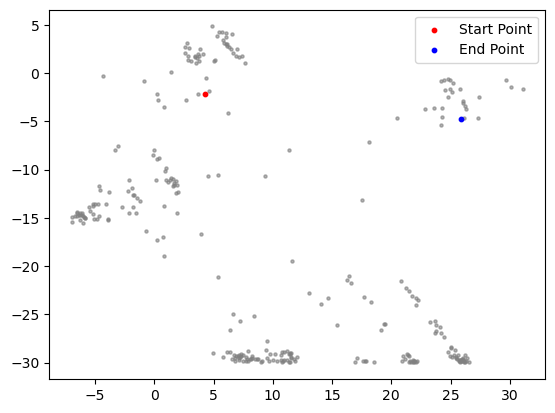

In [24]:
%matplotlib inline
_, ax = plt.subplots()
ax.scatter(first_last_x_coords, first_last_y_coords, c='gray', s=5, alpha=0.6)
ax.scatter(start_point_x, start_point_y, c='red', s=10, label='Start Point')
ax.scatter(end_point_x, end_point_y, c='blue', s=10, label='End Point')
ax.legend()

In [25]:
# from src.visualization.plot_vehicle_tracks_in_notebook import plot_vehicle_tracks_in_notebook
# plot_vehicle_tracks_in_notebook(plt.gca(), df_cuid=df_cuid, df_cuid_grouped=df_cuid_grouped, color='gray')

# point_label = 'Inlier' if outlier_results.in_hull == True and outlier_results.medoid_distance_similarity >= 2 else 'Outlier'
# plt.gca().scatter(*point[0][0], color='red', zorder=1000, label=point_label)

# for i in range(len(medoids)):
#     plt.gca().scatter(medoids[i][0], medoids[i][1], color='green', zorder=100, edgecolor='white')

# for i, hull in enumerate(hulls):
#     hull_with_closure = np.vstack([hull, hull[0]])  
#     plt.gca().plot(hull_with_closure[:,0], hull_with_closure[:,1], color='green', linestyle='--', zorder=100)
# plt.show()

In [26]:
# calculate the medoid distance similarity for all start and end points
medoid_distance_similarities = []
for i in range(len(X)):
    x = X[i][0]
    y = X[i][1]
     # calculate cluster with lowest distance to medoid for x_input and y_input
    input_point = [x, y]
    distances_to_medoids = cdist([input_point], medoids, 'euclidean')
    closest_medoid_cluster_index = np.argmin(distances_to_medoids)
    closest_medoid_distance = distances_to_medoids[0][closest_medoid_cluster_index]
    

    # get cluster index of second to lowest distance to medoid
    distances_to_medoids[0][closest_medoid_cluster_index] = np.inf
    second_closest_medoid_medoid_index = np.argmin(distances_to_medoids)
    second_clostes_medoid_distance = distances_to_medoids[0][second_closest_medoid_medoid_index]

    if closest_medoid_distance == 0:
        distance_similarity = np.inf
        medoid_distance_similarities.append(distance_similarity)
        continue

    distance_similarity = second_clostes_medoid_distance / closest_medoid_distance # ≥ 1

    medoid_distance_similarities.append(distance_similarity)

NameError: name 'medoids' is not defined

In [11]:
# filter out np.inf values
medoid_distance_similarities = np.array(medoid_distance_similarities)
medoid_distance_similarities_finite = medoid_distance_similarities[np.isfinite(medoid_distance_similarities)]
medoid_distance_similarities_finite_80_percentile = np.percentile(medoid_distance_similarities_finite, 80)
medoid_distance_similarities_finite_75_percentile = np.percentile(medoid_distance_similarities_finite, 75)
medoid_distance_similarities_finite_80_percentile_filtered = medoid_distance_similarities_finite[medoid_distance_similarities_finite <= medoid_distance_similarities_finite_80_percentile]
medoid_distance_similarities_infinite = medoid_distance_similarities[np.isinf(medoid_distance_similarities)]
inf_count = np.sum(np.isinf(medoid_distance_similarities))

In [12]:

# hist_fig = plt.figure()
# hist_fig = plt.hist(medoid_distance_similarities_finite_80_percentile_filtered, bins=200, label='finite distance similarities')
# hist_fig = plt.bar(max(medoid_distance_similarities_finite_80_percentile_filtered + 1), inf_count, color='red', width = 0.5, label = 'inf')
# plt.xlim(left=min(medoid_distance_similarities_finite_80_percentile_filtered), right = max(medoid_distance_similarities_finite_80_percentile_filtered) + 2)
# plt.show()

In [ ]:
print(f'Max similarity: {np.max(medoid_distance_similarities_finite)} in index {np.argmax(medoid_distance_similarities_finite)}')

In [ ]:
from matplotlib.colors import BoundaryNorm
from src.visualization.plot_vehicle_tracks_in_notebook import plot_vehicle_tracks_in_notebook


colored_dist_sim_fig = plt.figure()
color_cutoff = medoid_distance_similarities_finite_75_percentile
print(color_cutoff)
boundaries = np.concatenate([np.linspace(1, color_cutoff, 100), [max(medoid_distance_similarities_finite)]])
norm = BoundaryNorm(boundaries, ncolors=256, extend='max')
colored_dist_sim_fig = plt.scatter(X[:,0], X[:,1], c=medoid_distance_similarities, cmap='viridis', norm=norm, zorder=100, label='distance similarity of start and end points')
cbar = plt.colorbar(colored_dist_sim_fig)
cbar.set_label('Distance Similarity')
for i, hull in enumerate(hulls):
    hull_with_closure = np.vstack([hull, hull[0]])  
    if i == 0:
        plt.gca().plot(hull_with_closure[:,0], hull_with_closure[:,1], color='red', linestyle='--', zorder=1000, label='convex hulls')
    else:
        plt.gca().plot(hull_with_closure[:,0], hull_with_closure[:,1], color='red', linestyle='--', zorder=1000)
        

for i in range(len(medoids)):
    if i == 0:
        plt.gca().scatter(medoids[i][0], medoids[i][1], color='red', zorder=50, edgecolor='white', label='medoids', s=200)
    else:
        plt.gca().scatter(medoids[i][0], medoids[i][1], color='red', zorder=50, edgecolor='white', s=200)

plot_vehicle_tracks_in_notebook(plt.gca(), df_cuid=df_cuid, df_cuid_grouped=df_cuid_grouped, color='gray')
plt.gca().set_title('Distance similarity: $\\frac{d(x, medoid_{second closest})}{d(x, medoid_{closest})}$ \n \n color cutoff at 75th percentile')
plt.gcf().suptitle('Distance similarity of points to closest and second closest medoids with the clusters\' convex hulls')
plt.gca().scatter(*point[0][0], color='black', zorder=1000, label='Drawn Point', s=200, edgecolors='white')
plt.legend()
plt.show()

## testing dtw path fitting

In [12]:
# import dtw distance matrix
dtw_distance_matrix_path = f'{parent_parent_dir}/src/models/OUTLIER_DETECTION/OPTICS_MODELS/{intersection_name}_dtw_distance_matrix.json'
with open(dtw_distance_matrix_path) as f:
    dtw_distance_matrix = json.load(f)

In [13]:
min_samples = 5
max_eps = 60
metric='precomputed'
cluster_method = 'dbscan'
metrics_description = f'with min samples: {min_samples}\nmax_eps: {max_eps}\nmetric: DTW\nclustermethod: {cluster_method}'
optics_dtw_clustering = OPTICS(min_samples=min_samples,
                           max_eps=max_eps,
                           cluster_method=cluster_method,
                           metric=metric,
                           ).fit(dtw_distance_matrix)

In [ ]:
from src.models.optics.get_clusters_from_optics_labels import get_clusters_from_optics_labels
from src.visualization.render_vehicle_track_cluster_in_notebook import render_vehicle_track_cluster_in_notebook

clusters_dtw = get_clusters_from_optics_labels(optics_dtw_clustering.labels_)

render_vehicle_track_cluster_in_notebook(plt.gca(), df_cuid, df_cuid_grouped, clusters_dtw)
